In [187]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
def plot_matrix(mean_matrix, stddv_matrix, x_labels, y_labels, save_path, x_title='', y_title=''):
    fig, ax = plt.subplots(figsize=(9,9))
    ax.set_xlabel(x_title, labelpad=20)
    ax.set_ylabel(y_title)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xticks(range(len(x_labels)))
    ax.set_yticks(range(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.imshow(mean_matrix, cmap=plt.cm.OrRd)

    for i in range(len(mean_matrix)):
        for j in range(len(mean_matrix[0])):
            mean = mean_matrix[j,i]
            std =  stddv_matrix[j, i]
            ax.text(i, j, f"{mean:.2f}\n{std:.2f}", va='center', ha='center')
    if save_path:
        fig.savefig(save_path)

In [188]:
experiments_path = pathlib.Path("../masks_results")

In [189]:
head_data = {

}
for task_dir in experiments_path.iterdir():
    head_data[task_dir.stem] = {}
    for seed_dir in task_dir.iterdir():
        head_mask = np.load(seed_dir / "head_mask.npy")
        head_importance = np.load(seed_dir / "head_importance.npy")
        head_data[task_dir.stem][seed_dir.stem] = {
            "head_mask": head_mask,
            "head_importance": head_importance
        }


# Task wise overlap % of pruned masks for each seed

In [190]:
tasks = sorted(list(head_data.keys()))
seeds = head_data["MNLI"].keys()
results = np.zeros((len(seeds), len(tasks), len(tasks)))
for seed_idx, seed in enumerate(seeds):
    for task_1_idx, task_1 in enumerate(tasks):
        for task_2_idx, task_2 in enumerate(tasks):
            common_heads = np.sum(head_data[task_1][seed]["head_mask"] * head_data[task_2][seed]["head_mask"])
            results[seed_idx][task_1_idx][task_2_idx] = common_heads
            
mean_shared_heads = np.mean(results, axis=0)
std_shared_heads = np.std(results, axis=0, ddof=1)



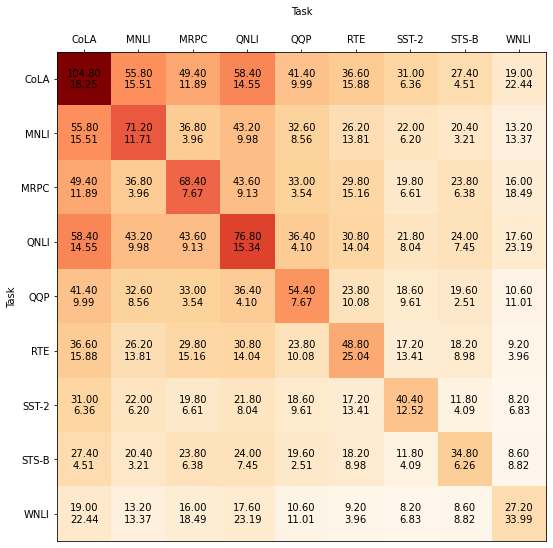

In [191]:
plot_matrix(mean_shared_heads, std_shared_heads, tasks, tasks, "task_v_task.pdf", "Task", "Task")

## Heads that generalize.

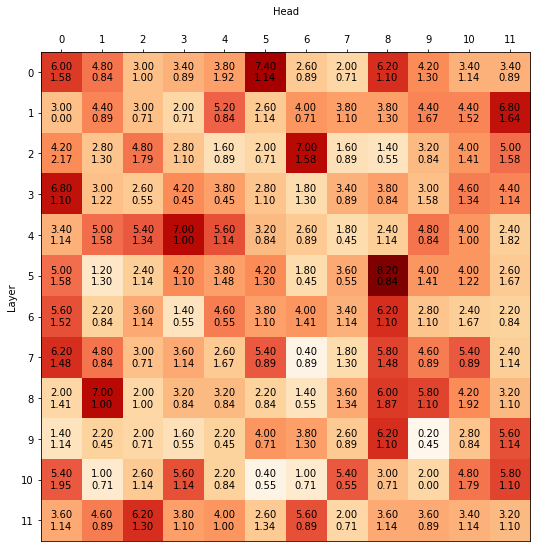

In [192]:
pruned_head_results = np.zeros((len(seeds), 12, 12)) # 12 layers with 12 heads each

for task_idx, task in enumerate(tasks):
    for seed_idx, seed in enumerate(seeds):
        pruned_head_results[seed_idx] += head_data[task][seed]["head_mask"]
mean_pruned_heads = np.mean(pruned_head_results, axis=0)
std_pruned_heads = np.std(pruned_head_results, axis=0, ddof=1)

plot_matrix(mean_pruned_heads, std_pruned_heads, list(map(str, range(12))), list(map(str, range(12))), "head_v_layer.pdf", "Head", "Layer")

## Head Importances before pruning

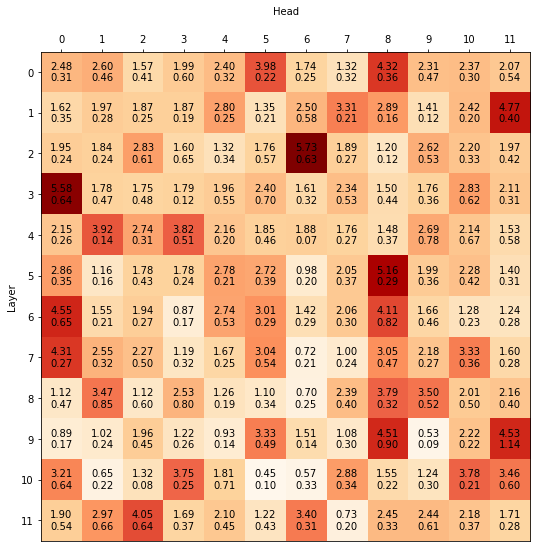

In [195]:
experiments_path = pathlib.Path("../head_importance_scores")
head_data = {

}
for task_dir in experiments_path.iterdir():
    head_data[task_dir.stem] = {}
    for seed_dir in task_dir.iterdir():
        head_importance = np.load(seed_dir / "head_importance.npy")
        head_data[task_dir.stem][seed_dir.stem] = {
            "head_importance": head_importance
        }
pruned_head_results = np.zeros((len(seeds), 12, 12)) # 12 layers with 12 heads each

for task_idx, task in enumerate(tasks):
    for seed_idx, seed in enumerate(seeds):
        pruned_head_results[seed_idx] += head_data[task][seed]["head_importance"]
mean_pruned_heads = np.mean(pruned_head_results, axis=0)
std_pruned_heads = np.std(pruned_head_results, axis=0, ddof=1)

plot_matrix(mean_pruned_heads, std_pruned_heads, list(map(str, range(12))), list(map(str, range(12))), None, "Head", "Layer")